In [4]:
# feature extractoring and preprocessing data
%matplotlib inline
import os
import pathlib
import csv
import cv2
import librosa
import librosa.display
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
import IPython.display as ipd

#Keras and Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,scale
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold,StratifiedKFold 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc

import warnings
warnings.filterwarnings('ignore')

AicovidVN115M: https://www.kaggle.com/blinkpm1/aicovidvn115m

COVID-19 Cough Recordings: https://www.kaggle.com/himanshu007121/coughclassifier-trial

These dataset is from `.wav` file so that I can extract diffenrent features that I want, and how I extract is different for phase 1 too.

# DATASET

Let's see what's in the 2 datasets. 

The metadata for Aicovid 115M dataset have file_path, gende, age and I am not gonna use them. The assessment_result (0: negative, 1:positive)

In [5]:
metadata_train_challenge = pd.read_csv('../input/aicovidvn115m/aicv115m_public_train/aicv115m_public_train/metadata_train_challenge.csv')
print('len metadata_train_challenge',len(metadata_train_challenge.iloc[:,-1]))
metadata_train_challenge.head(4)

len metadata_train_challenge 1199


,uuid,subject_gender,subject_age,assessment_result,file_path
0,3284bcf1-2446-4f3a-ac66-14c76b294177,male,23.0,0,3284bcf1-2446-4f3a-ac66-14c76b294177.wav
1,431334e1-5946-4576-bb51-8e342ccc22b4,NaN,NaN,0,431334e1-5946-4576-bb51-8e342ccc22b4.wav
2,1d6fac4b-1e7f-4bdc-81cd-3a720bfbb1e1,NaN,NaN,0,1d6fac4b-1e7f-4bdc-81cd-3a720bfbb1e1.wav
3,c7ee0695-b2e7-4beb-b904-f1455c9609d9,male,49.0,0,c7ee0695-b2e7-4beb-b904-f1455c9609d9.wav


In the file cough_trial_extended.csv have sowm information that the author have done before. 

In [6]:
cough_trial_extended = pd.read_csv('../input/coughclassifier-trial/cough_trial_extended.csv')
print('len cough_trial_extended',len(cough_trial_extended.iloc[:,-1]))
cough_trial_extended.head(4)

len cough_trial_extended 170


,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid


The ideal is to combine the 2 data into 1 csv file with 2 column, The first one is the file path and the second one is encoded labels (0: negative, 1:positive)

In [7]:
header = 'filePath label'
header = header.split()

file = open('data_file_Path.csv', 'w')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
data =[]
for i,label in enumerate(cough_trial_extended['class']):
    if label =='not_covid':
        label = '0'
    else:
        label = '1'
    filename = cough_trial_extended.iloc[i ,0]
    filePath = '../input/coughclassifier-trial/trial_covid/' + str(filename)
    data = [filePath, label]
    file = open('data_file_Path.csv', 'a')
    with file:
        writer = csv.writer(file)
        writer.writerow(data)


In [8]:
data =[]
for i,label in enumerate(metadata_train_challenge['assessment_result']):
    filename = metadata_train_challenge.iloc[i ,-1]
    filePath = '../input/aicovidvn115m/aicv115m_public_train/aicv115m_public_train/train_audio_files_8k/train_audio_files_8k/' + str(filename)
    data = [filePath, label]
    file = open('data_file_Path.csv', 'a')
    with file:
        writer = csv.writer(file)
        writer.writerow(data)
data = pd.read_csv('./data_file_Path.csv')
print ('len data', len(data.iloc[:,1]))
data.head(8)    

len data 1369


,filePath,label
0,../input/coughclassifier-trial/trial_covid/0v8...,0
1,../input/coughclassifier-trial/trial_covid/1j1...,0
2,../input/coughclassifier-trial/trial_covid/1MS...,0
3,../input/coughclassifier-trial/trial_covid/1Pa...,0
4,../input/coughclassifier-trial/trial_covid/cov...,1
5,../input/coughclassifier-trial/trial_covid/cov...,1
6,../input/coughclassifier-trial/trial_covid/cou...,1
7,../input/coughclassifier-trial/trial_covid/pos...,1


# PREPROCESSING
I will extract 2D features like:
* Mel-frequency Spectrogram
* chroma

And then combine them into image to feed into the model
I may add 1D features and mean them through time (not mean them on the whole audio like phase 1):
* MFCCs
* Spectral Centroid
* Spectral Bandwidth
* Spectral Roll-off
* ZCR + energy


In [9]:
Features = []
Number = len(data.iloc[:,1]) #Number of files I want to try on Number = len(data.iloc[:,1]) for all data
for file in data['filePath'][:Number]:

    y,sr=librosa.load(file)
    if librosa.get_duration(y=y, sr=sr) > 30:
        y,sr=librosa.load(file, duration = 30)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, S=None, n_fft=2048, 
                                              hop_length=512, win_length=None, window='hann', 
                                              center=True, pad_mode='reflect', power=2.0)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, S=None, norm=None, n_fft=2048, 
                                hop_length=512, win_length=None, window='hann', 
                                center=True, pad_mode='reflect', tuning=None, n_chroma=12)
    MFCC = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
    
    ZCR = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512, center=True)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, S=None, n_fft=2048, 
                                      hop_length=512, freq=None, win_length=None, window='hann', 
                                                          center=True, pad_mode='reflect')
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, S=None, n_fft=2048, 
                                       hop_length=512, win_length=None, window='hann', 
                                       center=True, pad_mode='reflect', freq=None, centroid=None, norm=True, p=2)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, S=None, n_fft=2048, 
                                     hop_length=512, win_length=None, window='hann', 
                                     center=True, pad_mode='reflect', freq=None, roll_percent=0.85)
    feature = np.concatenate((mel_spec,chroma_stft,MFCC,ZCR,spectral_centroid,spectral_bandwidth,spectral_rolloff), 
                             axis=0)
    feature = librosa.power_to_db(feature, ref=np.max)
    Features.append(feature)
    #print ('feature',feature.shape)
print ('Features',len(Features) )

Features 1369


**Visualize Data**

Had to convert these images into dB value to have a better view on the problem. Can see that I concaternate features with the vertical axis. It helps retain the time information. From there, our CRNN can work better

I didn't start audio file and what confused me was the compute the mean value for all features on time axis. I think that method destroy the data properties.

Some information need to be used on time axis to work well like Mel-spectrogram, MFCC or ZCR/energy. In fact, they usually combine ZCR/Energy to distinguish when it is sound and when it is not. When there is sound ZCR will suddenly decrease and energy suddenly rise at the same time

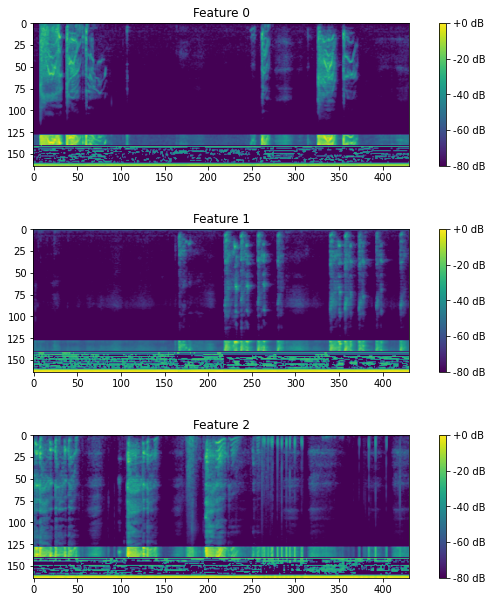

In [10]:
plt.figure(num='Features',figsize=(9,9))
for i, img in enumerate(Features[:3]):
    plt.subplot(3,1,i+1) 
    plt.title('Feature {}'.format(i))
    #S_dB = librosa.power_to_db(img, ref=np.max)
    #img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)        
    plt.imshow(img)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout(pad=3.0)
    #plt.axis('off')    
plt.show()

# PREPARE FOR TRAINING

This part is for displaying the length of data.

The majority of the files are around 15 seconds long. Only two files are longer than that, and they're far too lengthy (over 1 min). Shorten that file to 30 seconds. And it won't make much of a difference. Not to mention if I use the length of that file to padding other pictures. The dataset would be significantly distorted

max_length 1292


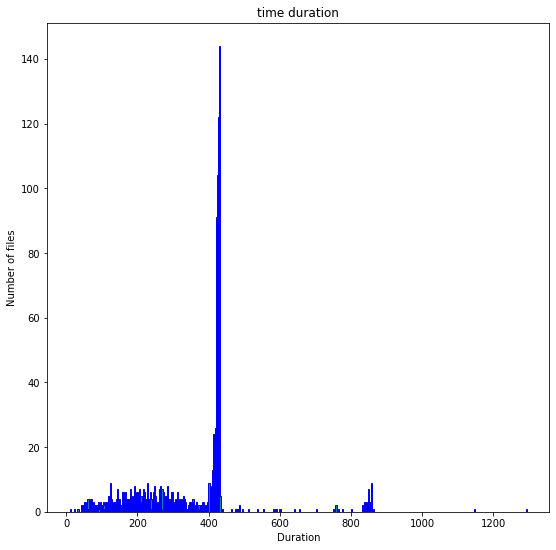

In [11]:
Time = np.array([x.shape[1] for x in Features])
unique, counts = np.unique(Time, return_counts=True)
#print (dict(zip(unique, counts)))
max_length = np.max(Time)
print ('max_length',max_length)

width = 3  # the width of the bars
plt.figure(num='Time',figsize=(9,9))
plt.xlabel('Duration')
plt.ylabel('Number of files')

plt.title('time duration')
plt.bar(unique,counts, width ,ec='blue')   
plt.show()

The range of file duration. We have 2 options:
1. Sorted padding with Batch
2. Padding on all the dataset based on the longest file
It's hard but tensorflow doesn't allow me to feed data with variable lengths into the model

I'd choose the first option because it's much more simple and faster

In [12]:

def preprocess(feature, featureSize):

    widthTarget, heightTarget = featureSize 
    height, width = feature.shape 

    # scale according to factor
    newSize = (int(width / 4),41) 
    #print ('newSize ={}, old size = {}'.format(newSize, feature.shape ))
    feature = cv2.resize(feature, newSize)
    # Normalization
    feature = scaler.fit_transform(feature)
    feature = np.pad(feature, ((0, 0), (0, widthTarget - feature.shape[1])), 'constant')
    #transpose
    feature = np.transpose(feature)
    
    return feature

We'll scale data and encode label

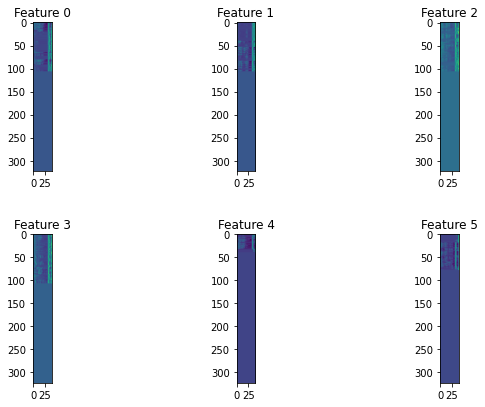

In [13]:
scaler = StandardScaler()
#print ('raw Features', Features[1])
scale_features =[]
for feature in Features[:Number]:
    feature = preprocess(feature,featureSize = (int(max_length/4),41)) #41 = 164/4
    scale_features.append(feature)

#print ('scale feature',scale_features[1])    
plt.figure(num='Features transpose',figsize=(9,9))

for i, img in enumerate(scale_features[:6]):
    plt.subplot(3,3,i+1) 
    plt.tight_layout(pad=3.0)
    plt.title('Feature {}'.format(i))
    plt.imshow(img)
    #plt.axis('off')    
plt.show()

In [14]:
genre_list = data.iloc[:Number, -1]
#print ('genre_list\n',genre_list)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
neg, pos = np.bincount(y)
total = neg + pos
print ('positive: {} ({:.2f}% of total) \nnegative cases: {}'.format(pos, 100 * pos/total ,neg))

positive: 481 (35.14% of total) 
negative cases: 888


Now we will padding the files

# Dividing data into TRAINING, VALIDATION and TEST set

Save the indices for the Data Augmentation stage

In [15]:
scale_features = np.array(scale_features).reshape(-1, int(max_length/4), 41, 1)
indices = range(len(scale_features))

In [16]:
x_train, x_test, y_train, y_test, indices_train,indices_test = train_test_split(scale_features, y, indices, test_size=0.15, shuffle = True, 
                                                    random_state = None, stratify = y)

X_train, X_valid, Y_train, Y_valid,Indices_train,Indices_valid = train_test_split(x_train, y_train,indices_train, test_size=0.2, shuffle = True, 
                                                    random_state = None, stratify = y_train )

Y_train = np_utils.to_categorical(Y_train, 2)
Y_valid = np_utils.to_categorical(Y_valid, 2)
print (len(Y_valid))

233


In [17]:
print ('\nlen(X_train)',len(X_train))
print ('len(X_valid)',len(X_valid))
print ('\n X_train.shape',X_train.shape)
print ('\n X_valid.shape',X_valid.shape)


len(X_train) 930
len(X_valid) 233

 X_train.shape (930, 323, 41, 1)

 X_valid.shape (233, 323, 41, 1)


# BUILDING MODEL

Used CRNN + attention due to it's power on time series data. The output will be flatten to classify 

In [18]:
def build_model(img_width = int(max_length/4),img_height = 41):
    # Inputs to the model

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    
    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2),strides = 2, name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), strides = 2, name="pool2")(x)

    # Third conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
  

    # Fourth conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)

    x = layers.MaxPooling2D((1, 2), name="pool4")(x)

    # Fifth conv block
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_1")(x)
    

    # Sixth conv block
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_2")(x)

    x = layers.MaxPooling2D((1, 2), name="pool6")(x)

    # Seventh conv block
    x = layers.Conv2D(
        512,
        (2, 2),
        activation="relu",
        kernel_initializer="he_normal",
        padding="valid",
        name="Conv7",
    )(x)


    # The number of filters in the last layer is 512. Reshape accordingly before
    # passing the output to the RNN part of the model

    new_shape = (int(max_length/16)-1,512) #Không cần downsampling #Nên coi shape lớp trước

    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    def attention_rnn(inputs):
        # inputs.shape = (batch_size, time_steps, input_dim)
        input_dim = int(inputs.shape[2])
        timestep = int(inputs.shape[1])
        a = layers.Permute((2, 1))(inputs) #Permutes the dimensions of the input according to a given pattern.
        a = layers.Dense(timestep, activation='softmax')(a) #// Alignment Model + Softmax
        a = layers.Lambda(lambda x: keras.backend.mean(x, axis=1), name='dim_reduction')(a)
        a = layers.RepeatVector(input_dim)(a)
        a_probs = layers.Permute((2, 1), name='attention_vec')(a)
        output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul') #// Weighted Average 
        return output_attention_mul

    x = attention_rnn(x)
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x  =layers.Flatten()(x)
    # Output layer
    
    x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.Dense(512 , activation="relu")(x)
    x = layers.Dense(256 , activation="relu")(x) # 
    
    y_pred = layers.Dense(2 , activation="softmax", name="last_dense")(x) # y pred
    model = keras.models.Model(inputs=input_img, outputs=y_pred, name="model")
    
    return model
model = build_model()
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 323, 41, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 323, 41, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 161, 20, 64)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 161, 20, 128) 73856       pool1[0][0]                      
______________________________________________________________________________________________

# TRAINING

Epoch 1/50
30/30 [==============================] - 135s 4s/step - loss: 1.3397 - val_loss: 1.1559
Epoch 2/50
30/30 [==============================] - 127s 4s/step - loss: 0.9112 - val_loss: 0.9444
Epoch 3/50
30/30 [==============================] - 128s 4s/step - loss: 0.7681 - val_loss: 0.9164
Epoch 4/50
30/30 [==============================] - 127s 4s/step - loss: 0.7270 - val_loss: 0.8008
Epoch 5/50
30/30 [==============================] - 127s 4s/step - loss: 0.6975 - val_loss: 0.6442
Epoch 6/50
30/30 [==============================] - 127s 4s/step - loss: 0.6670 - val_loss: 0.6327
Epoch 7/50
30/30 [==============================] - 127s 4s/step - loss: 0.6517 - val_loss: 0.6689
Epoch 8/50
30/30 [==============================] - 127s 4s/step - loss: 0.6585 - val_loss: 0.6177
Epoch 9/50
30/30 [==============================] - 127s 4s/step - loss: 0.6302 - val_loss: 0.6724
Epoch 10/50
30/30 [==============================] - 127s 4s/step - loss: 0.6529 - val_loss: 0.6252
Epoch 11/

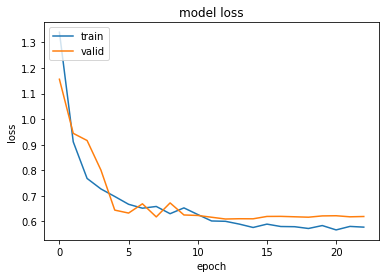

In [19]:
epochs = 50
batch_size = 32
early_stopping_patience = 10

def scheduler(epoch):
    if epoch <= 10:
        return 1e-3  
    elif 10 < epoch <=15:
        return 1e-4
    else:
        return 1e-5

# Add early stopping
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint(filepath='./covid_model/covid_model_{epoch:02d}.h5', 
                                    save_freq='epoch',
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True,
                                    period = 5),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]

model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy')                 

history = model.fit(x= X_train, y= Y_train, 
                validation_data=(X_valid, Y_valid),
                epochs = epochs, 
                batch_size = batch_size,
                callbacks = my_callbacks,
                )

# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./covid_model/covid_model_loss.png')
plt.show()

# TESTING

In [20]:
load_model =0
load_model = build_model()
load_model.load_weights('./covid_model/covid_model_10.h5')

In [21]:
predictions = []
predictions = model.predict(x_test)
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)
# print ('y_predict',y_predict)
# print ('y test\n', y_test)

In [22]:
import seaborn as sns
def evaluate_matrix(y_test, y_predict, name):
    cm = confusion_matrix(y_test, y_predict)
    cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])

    plt.figure(figsize=(10, 10))

    sns.set(font_scale=1)

    ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.ylabel("True labels",fontsize = 'x-large')
    plt.xlabel("Predicted labels",fontsize = 'x-large')
    plt.tight_layout()
    plt.title(name,fontsize = 'xx-large',pad = 20)

    plt.show()

    print(classification_report(y_test, y_predict, target_names=["Negative", "Positive"]))
    
#evaluate_matrix(y_test, y_predict,'Evaluate_matrix on orginal data')

In [23]:
def ROC_curve(y_test,predictions,name):
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions[:,1])
    print ('AUC = {:.3f}'. format( auc(lr_fpr, lr_tpr)))
    # plot the roc curve for the model
    lw = 2
    plt.plot(lr_fpr, lr_tpr, color="darkorange",
             lw=lw, label="ROC curve (area = %0.2f)" % auc(lr_fpr, lr_tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    # axis labels
    pyplot.xlabel('False Positive Rate',fontsize = 'x-large')
    pyplot.ylabel('True Positive Rate',fontsize = 'x-large')
    plt.title(name,fontsize = 'xx-large', pad =20)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

#ROC_curve(y_test,predictions,'AUC on original data')

# DATA AUGMENTATION

Methods:
* Time Shift
* Adding background noise
* Stretching the sound (just a little bit)
* Changing Gain

Note: You have to use data augmentation on just the train and valid set

In [24]:
#print ('indices_train',indices_train)  # This is the dataset that I used to split train, validation set
#print ('y_train',y_train)

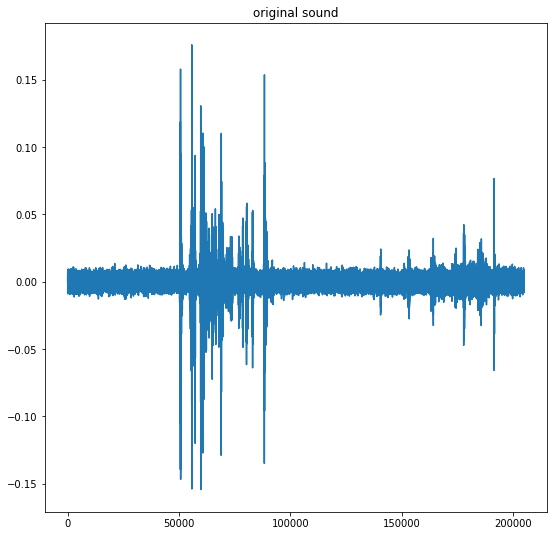

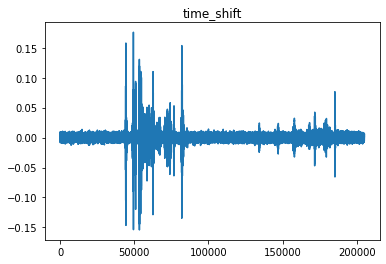

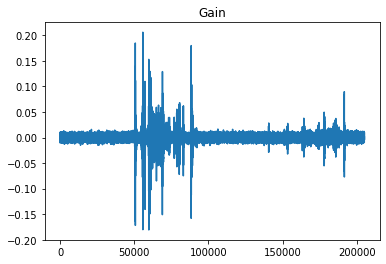

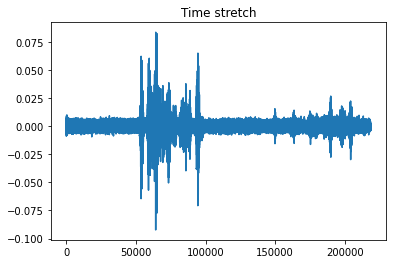

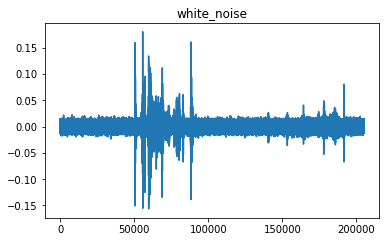

In [25]:
pos_indices = []
Aug_feature = []
for i,value in enumerate(y_train):
    if value == 1:
        pos_indices.append(indices_train[i])  
        
y, sr = librosa.load(data['filePath'][pos_indices[1]])        

def white_noise(y):
    wn = np.random.randn(len(y))
    y_wn = y + random.uniform(0, 0.005)*wn
    return y_wn

def time_shift(y):
    y = np.roll(y, random.randint(-10000,10000))
    return y

def Gain(y):
    y = y + random.uniform(-0.2,0.2)*y
    return y       
                            
def stretch(y, rate=random.uniform(0.8,1.2)):
    y = librosa.effects.time_stretch(y, rate)
    return y

plt.figure(num='Data Augmentation',figsize=(9,9))

plt.title ('original sound')
plt.plot(y) 
plt.show()

plt.title ('time_shift')
plt.plot(time_shift(y))
plt.show()

plt.title ('Gain')
plt.plot(Gain(y))
plt.show()

plt.title ('Time stretch')
plt.plot(stretch(y))
plt.show()

plt.title ('white_noise')
plt.plot(white_noise(y))

plt.tight_layout(pad=3.0)
#plt.axis('off')    
plt.show()

You can listen to these file to point out the diferences

In [26]:
print ('white noise')
ipd.Audio(white_noise(y), rate=sr)

white noise


In [27]:
print ('time shift')
ipd.Audio(time_shift(y), rate=sr)

time shift


In [28]:
print ('Gain')
ipd.Audio(Gain(y), rate=sr)

Gain


In [29]:
print ('time stretch')
ipd.Audio(stretch(y),rate=sr)

time stretch


Due to the dataset imbalanced problems as the result above
> positive: 481 (35.14% of total) 
> negative cases: 888

In [30]:
num_aug = (neg - pos)/1.5
if num_aug > len(pos_indices):
    iteration = int(num_aug/len(pos_indices))
else:
    iteration =1
print ('Number of file generated based on one positive case',iteration)

for file in data['filePath'][pos_indices]:
    if librosa.get_duration(y=y, sr=sr) > 30:
        y,sr=librosa.load(file, duration = 30)
    for i in range (iteration):
        y,sr=librosa.load(file)
        
        chance = random.randint(0,100)
        if chance <=20:
            stretch(y)
        if chance <=40:
            time_shift(y)
        if chance <=60:
            Gain(y)
        if chance <=80:
            white_noise(y)

        ZCR = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512, center=True)
        if ZCR.shape[1] >= max_length:
            continue
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, S=None, n_fft=2048, 
                                                  hop_length=512, win_length=None, window='hann', 
                                                  center=True, pad_mode='reflect', power=2.0)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, S=None, norm=None, n_fft=2048, 
                                    hop_length=512, win_length=None, window='hann', 
                                    center=True, pad_mode='reflect', tuning=None, n_chroma=12)
        MFCC = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)


        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, S=None, n_fft=2048, 
                                          hop_length=512, freq=None, win_length=None, window='hann', 
                                                              center=True, pad_mode='reflect')

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, S=None, n_fft=2048, 
                                           hop_length=512, win_length=None, window='hann', 
                                           center=True, pad_mode='reflect', freq=None, centroid=None, norm=True, p=2)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, S=None, n_fft=2048, 
                                         hop_length=512, win_length=None, window='hann', 
                                         center=True, pad_mode='reflect', freq=None, roll_percent=0.85)
        aug_feature = np.concatenate((mel_spec,chroma_stft,MFCC,ZCR,spectral_centroid,spectral_bandwidth,spectral_rolloff), 
                                 axis=0)
        aug_feature = librosa.power_to_db(aug_feature, ref=np.max)
        Aug_feature.append(aug_feature)
    #print ('Aug_feature',Aug_feature.shape)
print ('Aug_feature',len(Aug_feature) )        

Number of file generated based on one positive case 1
Aug_feature 409


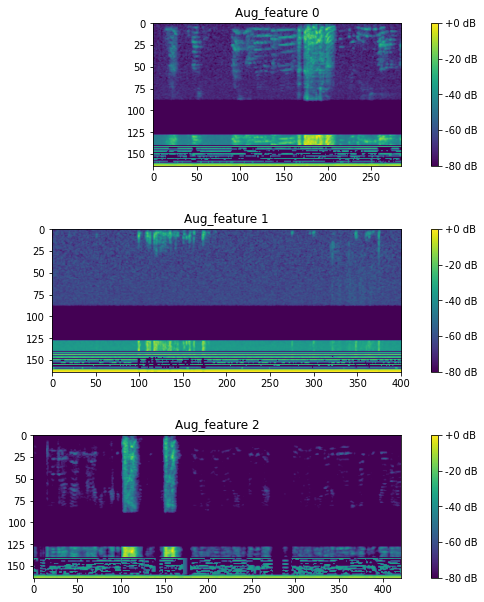

In [31]:
plt.figure(num='Aug_feature',figsize=(9,9))
for i, img in enumerate(Aug_feature[:3]):
    plt.subplot(3,1,i+1) 
    plt.title('Aug_feature {}'.format(i))      
    plt.imshow(img)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout(pad=3.0)
    #plt.axis('off')    
plt.show()

In [32]:
y_aug = np.ones((1,len(Aug_feature)),dtype = np.uint8)[0]
#print (y_aug)

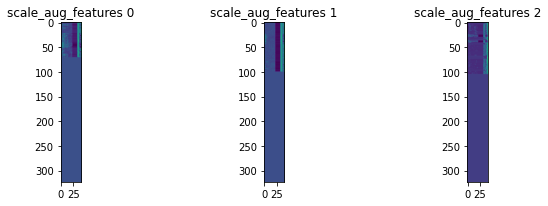

In [33]:
scale_aug_features =[]
for feature in Aug_feature:
    feature = preprocess(feature,featureSize = (int(max_length/4),41)) #41 = 164/4
    scale_aug_features.append(feature)

#print ('scale feature',scale_features[1])    
plt.figure(num='Features transpose',figsize=(9,9))

for i, img in enumerate(scale_aug_features[:3]):
    plt.subplot(3,3,i+1) 
    plt.tight_layout(pad=3.0)
    plt.title('scale_aug_features {}'.format(i))
    plt.imshow(img)
    #plt.axis('off')    
plt.show()

Combine augmented data with x_train data, then divide it into train and valid sets.

In [34]:
scale_aug_features = np.array(scale_aug_features).reshape(-1, int(max_length/4), 41, 1)
x_train = np.concatenate((x_train,scale_aug_features), axis=0)
print (len(x_train))

1572


In [35]:
y_train = np.concatenate((y_train,y_aug), axis=0)

In [36]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle = True, 
                                                    random_state = None, stratify = y_train )

Y_train = np_utils.to_categorical(Y_train, 2)
Y_valid = np_utils.to_categorical(Y_valid, 2)
#print (Y_valid)
print (len(Y_valid))
print('X_train.shape',X_train.shape)
print('X_valid.shape',X_valid.shape)

315
X_train.shape (1257, 323, 41, 1)
X_valid.shape (315, 323, 41, 1)


In [37]:
new_model = 0
new_model = build_model()

Epoch 1/50
40/40 [==============================] - 180s 4s/step - loss: 1.3173 - val_loss: 1.5613
Epoch 2/50
40/40 [==============================] - 172s 4s/step - loss: 0.9180 - val_loss: 1.4652
Epoch 3/50
40/40 [==============================] - 172s 4s/step - loss: 0.7619 - val_loss: 1.0956
Epoch 4/50
40/40 [==============================] - 172s 4s/step - loss: 0.7083 - val_loss: 0.6868
Epoch 5/50
40/40 [==============================] - 175s 4s/step - loss: 0.6817 - val_loss: 0.6552
Epoch 6/50
40/40 [==============================] - 174s 4s/step - loss: 0.6892 - val_loss: 0.6741
Epoch 7/50
40/40 [==============================] - 174s 4s/step - loss: 0.6543 - val_loss: 0.6845
Epoch 8/50
40/40 [==============================] - 173s 4s/step - loss: 0.6613 - val_loss: 0.6952
Epoch 9/50
40/40 [==============================] - 171s 4s/step - loss: 0.6574 - val_loss: 0.6588
Epoch 10/50
40/40 [==============================] - 171s 4s/step - loss: 0.6409 - val_loss: 0.6597
Epoch 11/

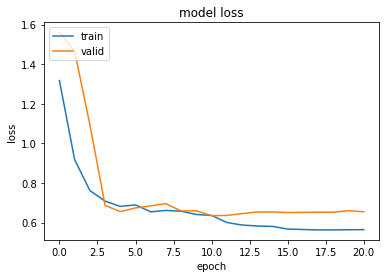

In [38]:
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint(filepath='./covid_model/new_covid_model_{epoch:02d}.h5', 
                                    save_freq='epoch',
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True,
                                    period = 5),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]

new_model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy')                 

new_history = new_model.fit(x= X_train, y= Y_train, 
                validation_data=(X_valid, Y_valid),
                epochs = epochs, 
                batch_size = batch_size,
                callbacks = my_callbacks,
                )

# list all data in history
print(new_history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./covid_model/new_covid_model_loss.png')
plt.show()

In [39]:
new_load_model = 0
new_load_model = build_model()
new_load_model.load_weights('./covid_model/new_covid_model_10.h5')

OSError: Unable to open file (unable to open file: name = './covid_model/new_covid_model_10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [40]:
new_predictions = []
new_predictions = new_load_model.predict(x_test)
y_new_predict =[]
for i in range(len(new_predictions)):
    predict = np.argmax(new_predictions[i])
    y_new_predict.append(predict)
#print ('y_predict',y_predict)
#print ('y test\n', y_test)

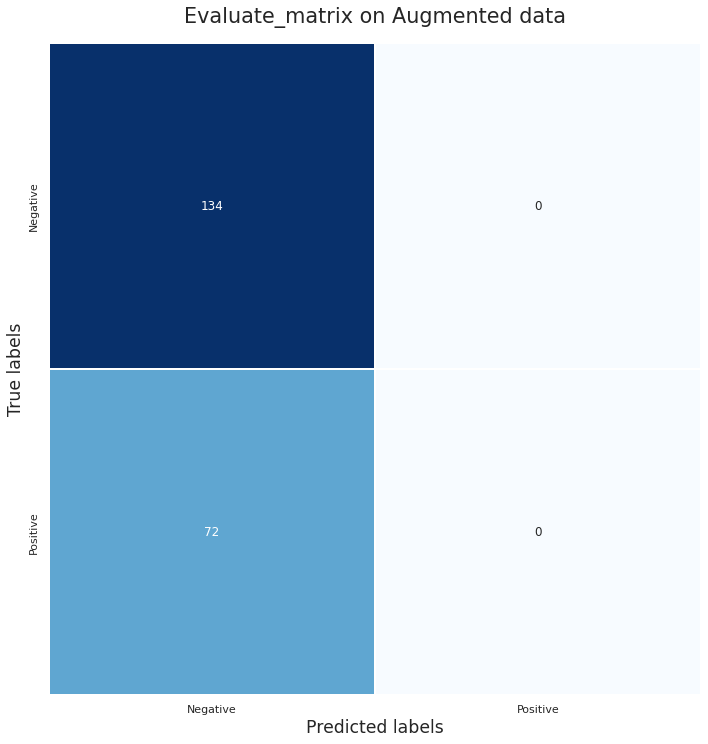

              precision    recall  f1-score   support

    Negative       0.65      1.00      0.79       134
    Positive       0.00      0.00      0.00        72

    accuracy                           0.65       206
   macro avg       0.33      0.50      0.39       206
weighted avg       0.42      0.65      0.51       206

AUC = 0.434


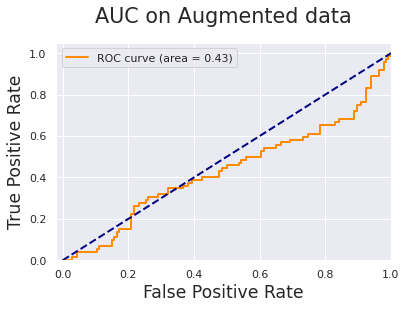

In [41]:
evaluate_matrix(y_test, y_new_predict,'Evaluate_matrix on Augmented data')
ROC_curve(y_test,new_predictions,'AUC on Augmented data')

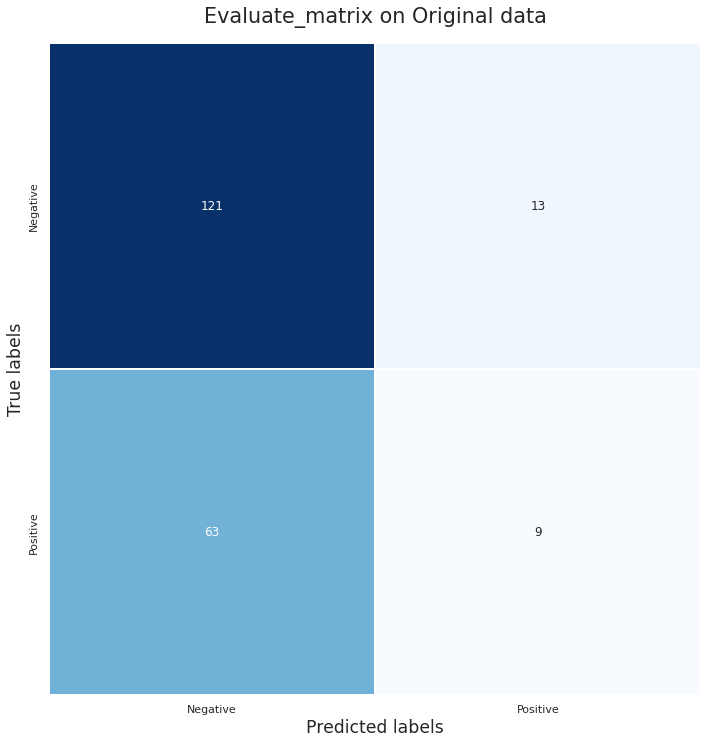

              precision    recall  f1-score   support

    Negative       0.66      0.90      0.76       134
    Positive       0.41      0.12      0.19        72

    accuracy                           0.63       206
   macro avg       0.53      0.51      0.48       206
weighted avg       0.57      0.63      0.56       206

AUC = 0.633


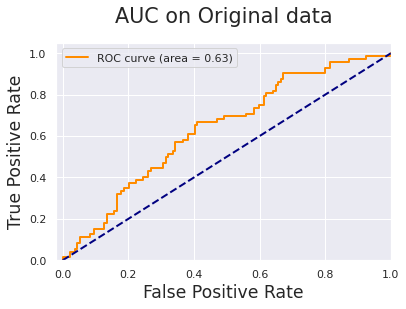

In [42]:
evaluate_matrix(y_test, y_predict,'Evaluate_matrix on Original data')
ROC_curve(y_test,predictions,'AUC on Original data')

After using Data Augmentation, Our predictions were undeniably better
The accuracy rise but it's not the matter cause the topic like this usually evaluate with other metrics
* the positive metrics are all increase (that's good)